# Was a website redesign successful?

*[A DataCamp challenge](https://www.datacamp.com)*

![](img/webpage-redesign-test.jpg)

May, 2023
> *A/B Testing*

## The project
You work for an early-stage startup in Germany. Your team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join your site. 

They have been testing the changes for a few weeks and now they want to measure the impact of the change and need you to determine if the increase can be due to random chance or if it is statistically significant.

The team assembled the following data file:

- `treatment` - "yes" if the user saw the new version of the landing page, no otherwise.
- `new_images` - "yes" if the page used a new set of images, no otherwise.
- `converted` - 1 if the user joined the site, 0 otherwise.

The control group is those users with "no" in both columns: the old version with the old set of images.

Complete the following tasks:

1. Analyze the conversion rates for each of the four groups: the new/old design of the landing page and the new/old pictures.
2. Can the increases observed be explained by randomness?
3. Which version of the website should they use?

In [46]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import my_functions as my

# Read tha data
df = pd.read_csv('data/redesign.csv')
print(df)

      treatment new_images  converted
0           yes        yes          0
1           yes        yes          0
2           yes        yes          0
3           yes         no          0
4            no        yes          0
...         ...        ...        ...
40479        no         no          0
40480       yes        yes          0
40481       yes        yes          0
40482        no         no          0
40483       yes        yes          0

[40484 rows x 3 columns]


## Data validation

In [47]:
# Show info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


Let's see if the four groups are equally represented in the data.

In [48]:
# Check the counts distribution of different groups
df[['treatment', 'new_images']].value_counts(normalize=True)

treatment  new_images
no         no            0.25
           yes           0.25
yes        no            0.25
           yes           0.25
dtype: float64

Yes, they are. They are equally represented so it will help reduce bias.

## Data analysis

I will calculate the conversion rates for each group.

In [49]:
df.groupby(['treatment', 'new_images'])['converted'].mean()

treatment  new_images
no         no            0.107104
           yes           0.112538
yes        no            0.120047
           yes           0.113724
Name: converted, dtype: float64

Let's visualize these values in a graph.

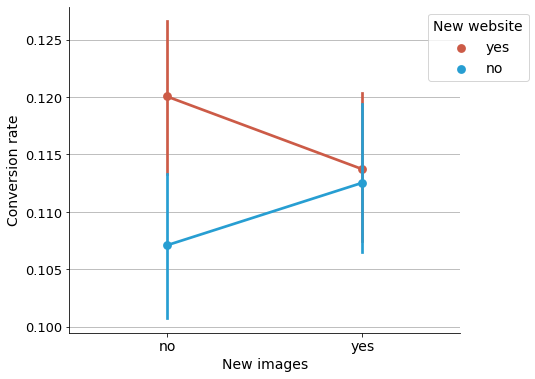

In [50]:
# Plot
fig, ax = plt.subplots(figsize=(7, 6))

sns.pointplot(ax=ax, x='new_images', y='converted', data=df, hue='treatment',
              order=['no', 'yes'], palette=['#cc5b47', '#279ed2'])

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlabel("New images", size=14)
ax.set_ylabel("Conversion rate", size=14)
ax.legend(title='New website', loc='upper left', bbox_to_anchor=(0.9, 1),
          fontsize=14, title_fontsize=14)
sns.despine()

plt.show()

This is what we can see:
- The control group, represented by the left-blue dot, has the lowest conversion rate among the four groups.
- If new images are displayed in the same webpage design (blue-right), the conversion rate increases, but the confidence intervals overlap with the control group, suggesting that the difference may not be significant.
- The same is true when the new website design is shown together with the new set of images (red-right)
- However, there appears to be a clearer difference in comparison to the control group if the new website design is presented *but* the images remain unchanged (red-left)

I will calculate the mean-value distributions and represent them in a graph.

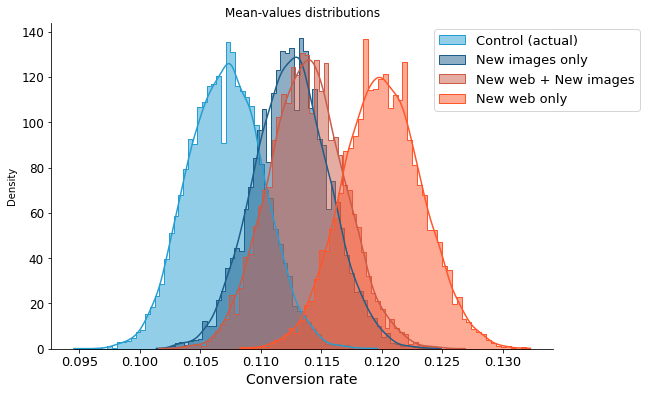

In [51]:
# Create arrays with the values of each group
treatno_imgno = df.loc[(df['treatment'] == 'no') & (df['new_images'] == 'no'), 'converted'].to_numpy()
treatno_img = df.loc[(df['treatment'] == 'no') & (df['new_images'] == 'yes'), 'converted'].to_numpy()
treat_imgno = df.loc[(df['treatment'] == 'yes') & (df['new_images'] == 'no'), 'converted'].to_numpy()
treat_img = df.loc[(df['treatment'] == 'yes') & (df['new_images'] == 'yes'), 'converted'].to_numpy()

# Set random number seed
np.random.seed(42)

# Draw bootstrap replicates and store their mean values
bs_reps_treatno_imgno = my.draw_bs_reps(treatno_imgno, np.mean, size=10000)
bs_reps_treatno_img = my.draw_bs_reps(treatno_img, np.mean, size=10000)
bs_reps_treat_imgno = my.draw_bs_reps(treat_imgno, np.mean, size=10000)
bs_reps_treat_img = my.draw_bs_reps(treat_img, np.mean, size=10000)

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

sns.color_palette('Paired')

sns.histplot(bs_reps_treatno_imgno, ax=ax, kde=True, stat="density", element="step",
             color='#279ed2', label="Control (actual)")

sns.histplot(bs_reps_treatno_img, ax=ax, kde=True, stat="density", element="step",
             color='#1d5e8a', label="New images only")

sns.histplot(bs_reps_treat_img, ax=ax, kde=True, stat="density", element="step",
             color='#cc5b47', label="New web + New images")

sns.histplot(bs_reps_treat_imgno, ax=ax, kde=True, stat="density", element="step",
             color='#ff562c', label="New web only")

ax.set_title("Mean-values distributions", size=12)
ax.tick_params(axis='x', labelsize=13, rotation=0)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel("Conversion rate", size=14)
ax.legend(loc='upper left', bbox_to_anchor=(0.75, 1), fontsize=13)
sns.despine()
    
plt.show()

As with the previous graph, it appears that the 95% confidence interval of the control group does not overlap with that of the "New web only" version of the page, but a hypothesis test is necessary to confirm this.

## Hypothesis testing
The null hypothesis I will consider is that the differences in mean values are purely due to chance, with all groups having the same distribution of mean values.

I will define a function that performs the following tasks:
1. Takes two measurement arrays and calculates the difference of their mean values.
2. Concatenates those measurement arrays in a single array to calculate combined mean value.
3. Shifts each array's values to have the same combined mean.
4. Computes 10,000 bootstrap replicates, storing the mean of each of them.
5. Checks all 10,000 mean values to see how many of them resulted in a difference equal to or greater than the one we measured. Dividing by the number of samples (10,000) will give us the p-value.

In [52]:
# Define function
def cal_p_value(arrayh, arrayl):
    '''Calculates p-value by bootstrapping arrays and getting mean differences'''

    # Compute the difference of means
    diff_means = np.mean(arrayh) - np.mean(arrayl)
    
    # Concatenate arrays
    concat = np.concatenate((arrayh, arrayl))
    
    # Compute mean of all
    mean_concat = np.mean(concat)
    
    # Generate shifted arrays
    arrayh_shifted = arrayh - np.mean(arrayh) + mean_concat
    arrayl_shifted = arrayl - np.mean(arrayl) + mean_concat
    
    # Compute 10,000 bootstrap replicates from shifted arrays
    bs_reps_arrayh_shifted = my.draw_bs_reps(arrayh_shifted, np.mean, size=10000)
    bs_reps_arrayl_shifted = my.draw_bs_reps(arrayl_shifted, np.mean, size=10000)
    
    # Get replicates of difference of means
    bs_reps_diff = bs_reps_arrayh_shifted - bs_reps_arrayl_shifted
    
    # Compute p-value
    p = np.sum(bs_reps_diff >= diff_means) / len(bs_reps_diff)
    
    return p

# Calculate p-value of only new images
p_treatno_img = cal_p_value(treatno_img, treatno_imgno)
print(f"\n{p_treatno_img} <- p-value 'New images' only")

# Calculate p-value of new webpage + new images
treat_img = cal_p_value(treat_img, treatno_imgno)
print(f"\n{treat_img} <- p-value 'New webpage + New images'")

# Calculate p-value of only new webpage
treat_imgno = cal_p_value(treat_imgno, treatno_imgno)
print(f"\n{treat_imgno} <- p-value 'New webpage' only\n")


0.1059 <- p-value 'New images' only

0.067 <- p-value 'New webpage + New images'

0.0016 <- p-value 'New webpage' only



The lowest p-value obtained was 0.0016 (0.16%), which is lower than a significance level of 5%. This indicates that out of 10,000 random tests, only 16 of them resulted in a difference in mean values equal to or greater than the one we observed. This is a very small number, suggesting that it would occur very rarely. Therefore, we can reject the null hypothesis in this case and conclude that the difference in the conversion rate is likely due to the difference in the web page design without new images.

In the other two, the p-values of 0.067 (6.7%) and 0.1059 (10.59%) indicate that there are higher chances of having those differences occur by chance. As they are above the significance level of 5%, we cannot draw the same conclusion as before and we fail to reject the null hypothesis in these cases.

## Conclusion
They should definitely use **the new version of the landing webpage without the new set of images**.